In [97]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import copy

In [98]:
load_model = models.vgg19_bn(weights="IMAGENET1K_V1")
print(load_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [99]:
load_model.eval()
with torch.no_grad():
    print(load_model(torch.randn(2,3,224,224)).shape)

torch.Size([2, 1000])


In [100]:
!pip install torchinfo
from torchinfo import summary
summary(load_model, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1000]                 --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [2, 64, 224, 224]         128
│    └─ReLU: 2-3                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [2, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [2, 64, 224, 224]         128
│    └─ReLU: 2-6                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [2, 128, 112, 112]        256
│    └─ReLU: 2-10                        [2, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [2, 128, 112, 112]        147,

In [101]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(256)), # 숫자 하나만 쓰면 짧은 쪽이 256이 되도록 resize!
    transforms.CenterCrop(size=(224,224)),
    ])

In [102]:
# 파일 다운로드
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

# 파일 읽기 및 dictionary로 변환
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read()) # dictionary로 바꿀 수 있게 eval 사용해서 str -> dict 로

print(idx2label)

--2025-03-25 11:29:59--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt.8’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2025-03-25 11:29:59 (2.89 MB/s) - ‘imagenet1000_clsidx_to_labels.txt.8’ saved [30564/30564]

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8:

In [103]:
idx2label[30]

'bullfrog, Rana catesbeiana'

<ipython-input-104-59866745097b>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  X = imageio.imread("https://hips.hearstapps.com/hmg-prod/images/cats-that-look-like-tigers-toyger-1562690831.jpg?crop=0.668xw:1.00xh;0.0544xw,0&resize=980:*")


<class 'numpy.ndarray'>
(978, 980, 3)
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


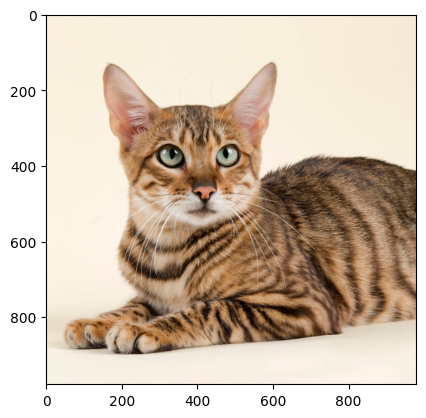

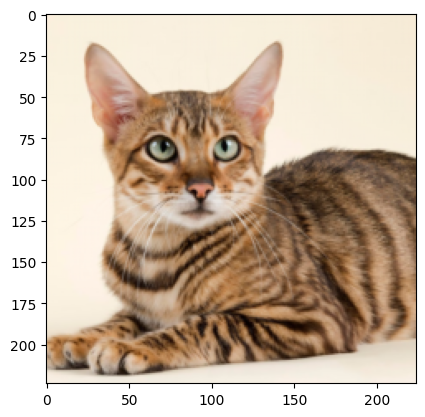

In [104]:
import imageio
X = imageio.imread("https://hips.hearstapps.com/hmg-prod/images/cats-that-look-like-tigers-toyger-1562690831.jpg?crop=0.668xw:1.00xh;0.0544xw,0&resize=980:*")

print(type(X))
print(X.shape)
plt.imshow(X)

X=transform(X)
print(type(X))
print(X.shape)
plt.figure()
plt.imshow(X.permute(1,2,0))

X = X.unsqueeze(dim=0)
print(X.shape)

In [105]:
load_model.eval()
with torch.no_grad():
    y_hat_sorted = load_model(X).sort(descending=True)
    # print(y_hat_sorted)
    percent_top5 = F.softmax(y_hat_sorted[0], dim=1)[0,:5]*100
    # print(percent_top5)
    pred_top5 = y_hat_sorted[1][0,:5] # sort 하고나서 [1]에 index가 담겨있음
    # print(pred_top5)
for i, idx in enumerate(pred_top5):
    print(idx2label[idx.item()],end="")
    print(f" ({round(percent_top5[i].item(),1)} %)")

Egyptian cat (77.9 %)
tabby, tabby cat (14.3 %)
tiger cat (7.7 %)
lynx, catamount (0.0 %)
quilt, comforter, comfort, puff (0.0 %)


Text(0.5, 1.0, '77.9 %  Egyptian cat')

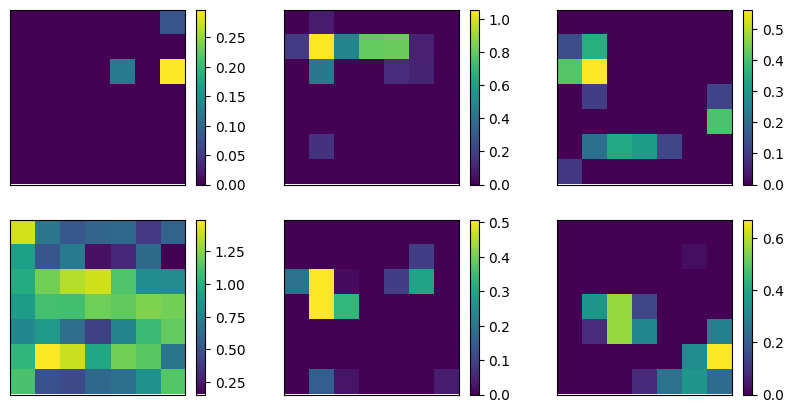

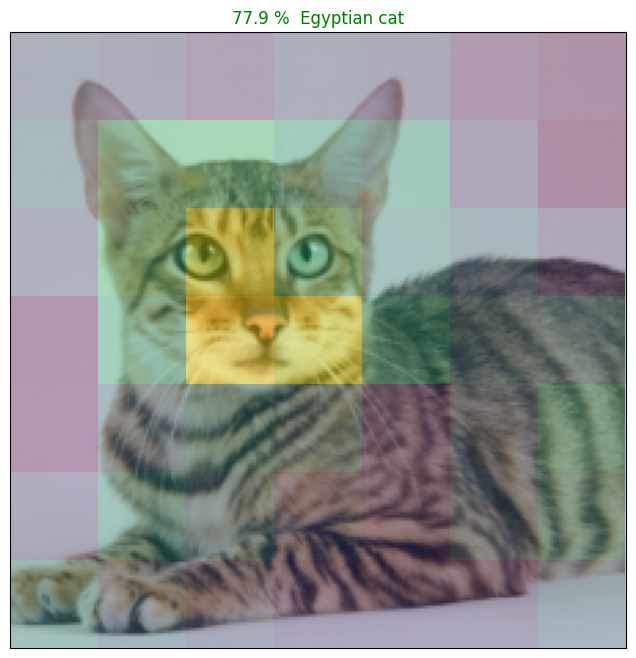

In [106]:
load_model.eval()
with torch.no_grad():
    X_feature = load_model.features(X)

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1, xticks=[], yticks=[])
    plt.imshow(X_feature[0,i])
    plt.colorbar()

summed_map = X_feature.sum(dim=1)
plt.figure(figsize=(8,8))
plt.xticks([]); plt.yticks([])
plt.imshow(X[0].cpu().permute(1,2,0))
plt.imshow(summed_map[0], extent=[0,224,224,0], alpha=0.4)
pred_class = idx2label[pred_top5[0].item()]
plt.title(f"{round(percent_top5[0].item(),1)} %  {pred_class}", color="g")